In [295]:
# Import libraries
import sqlite3 
import requests
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import datetime

!pip install pymongo
import pymongo
    

In [296]:
# Connect database and creating cursor
# I will be setting the limit for 2 in order not to surpass daily API call limit
conn = sqlite3.connect('database.sqlite', detect_types=sqlite3.PARSE_COLNAMES)
c = conn.cursor()


c.execute("""SELECT Match_ID, Unique_Team_ID, Unique_Team, Season, Date, HomeTeam, AwayTeam, FTHG, FTAG, FTR 
            FROM FlatView_Advanced WHERE Season = '2011' GROUP BY Match_ID ORDER BY Match_ID limit 2;""")

df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]

In [297]:
# 'rainy_day' feature engineering for every game day in 2011 using DarkSky.net weather API
df['Rainy_Day'] = False

for index, row in df.iterrows():
    time = str(int(datetime.datetime.strptime(row['Date'], "%Y-%m-%d").timestamp())) # unix timestamp from date, casting for API format
    response = requests.get('https://api.darksky.net/forecast/13e9efb8811df5d1b55434bb80abe89e/52.520008,13.404954,' + time).json()
    # print(response['currently']['icon'])
    # print(row['Rainy_Day'])
    if 'rain' in response['currently']['icon']:
        df.at[index,'Rainy_Day'] = True
    else:
        df.at[index,'Rainy_Day'] = False

df.head()

,Match_ID,Unique_Team_ID,Unique_Team,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Rainy_Day
0,1092,1,Bayern Munich,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A,False
1,1093,1,Bayern Munich,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A,False


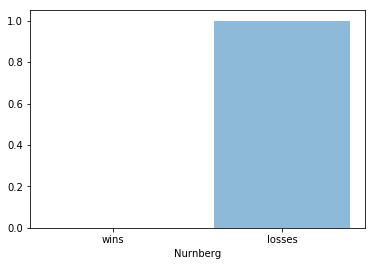

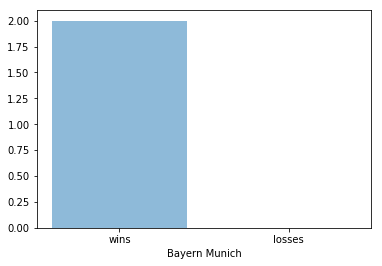

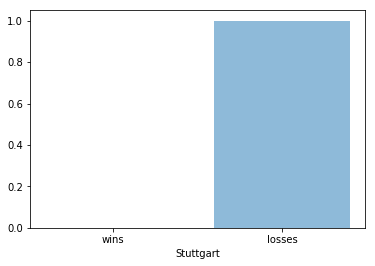

In [298]:
# Create WeatherGetter class including main functions to manipulate dataframe

class WeatherGetter():
    
# Calculate total goals  
    def total_goals(team):
        goals = []
        for unique_team in df.Unique_Team:
            for n in range(len(df.Unique_Team)):
                if team == df.HomeTeam[n]:
                    goals.append(df.FTHG[n])
                elif team == df.AwayTeam[n]:
                    goals.append(df.FTAG[n])
#             print(goals)
            return sum(goals)

# Calculate total wins
    def total_wins(team):
        wins = []
        for unique_team in df.Unique_Team:
            for n in range(len(df.Unique_Team)):
                if team == df.HomeTeam[n] and df.FTR[n] == 'H':
                    wins.append(1)
                elif team == df.AwayTeam[n] and df.FTR[n] == 'A':
                    wins.append(1)
            return sum(wins)
        
# Calculate total losses        
    def total_losses(team):
        loss = []
        for unique_team in df.Unique_Team:
            for n in range(len(df.Unique_Team)):
                if team == df.HomeTeam[n] and df.FTR[n] == 'A':
                    loss.append(1)
                elif team == df.AwayTeam[n] and df.FTR[n] == 'H':
                    loss.append(1)
            return sum(loss)

# Get teams that played in 2011
    def get_teams(df):
        teams = df.HomeTeam.append(df.AwayTeam)
        unique_teams = list(set(teams))
        return unique_teams
    
# Calculate wins on rainy days    
    def rainy_wins(team):
        rainy_wins = []
        for unique_team in df.Unique_Team:
            for n in range(len(df.Unique_Team)):
                if team == df.HomeTeam[n] and df.FTR[n] == 'H' and df.Rainy_Day[n] == True:
                    rainy_wins.append(1)
                elif team == df.AwayTeam[n] and df.FTR[n] == 'A' and df.Rainy_Day[n] == True:
                    rainy_wins.append(1)
            return sum(rainy_wins)

# Calculate rainy day percentage
    def rainy_wins_perc(team):
        if WeatherGetter.total_wins(team) == 0:
            return 0
        else:
            return WeatherGetter.rainy_wins(team)/WeatherGetter.total_wins(team)

# Plot wins and losses for each team in 2011 season
    def plot(df):
        for idx, team in enumerate(WeatherGetter.get_teams(df)):
            wins = WeatherGetter.total_wins(team)
            losses = WeatherGetter.total_losses(team)
            team = team
        
            plt.bar([0,1], [wins,losses], alpha=0.5, tick_label=['wins','losses'])
            plt.xlabel(team)
            plt.show()
    
WeatherGetter.plot(df)


In [299]:
# Create DataFrame for MongoDB migration
# Columns: teamName, totalGoals, totalWins, wins_losses_viz, perc_rain_wins

def getYrStats(df):
    stats = []
    for idx, team in enumerate(WeatherGetter.get_teams(df)):
        stats.append({
            'teamId' : idx + 1,
            'teamName' : str(team),
           ' totalGoals' : int(WeatherGetter.total_goals(team)),
            'totalWins' : int(WeatherGetter.total_wins(team)),
           # 'wins_losses_viz' : wins_losses_viz(team),
            'perc_rain_wins' : float(WeatherGetter.rainy_wins_perc(team))
       })
    return stats # we can feed this directly to MongoDB

statsDF = pd.DataFrame(getYrStats(df))
statsDF.head()

,totalGoals,perc_rain_wins,teamId,teamName,totalWins
0,0,0.0,1,Nurnberg,0
1,3,0.0,2,Bayern Munich,2
2,1,0.0,3,Stuttgart,0


In [286]:
# Dump DataFrame (or list) to MongoDB instance
class MongoHandler():
    def mongo(self):
        myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/")
        db = myclient['mod2_db']
        coll = db.mod2_db['soccer_league_2011']
        results = coll.insert_many(getYrStats(df)) # passing in a list of dictionaries
        return results.inserted_ids   
        
MongoHandler().mongo()

[ObjectId('5ce46473f9a066fc171107cc'),
 ObjectId('5ce46473f9a066fc171107cd'),
 ObjectId('5ce46473f9a066fc171107ce')]